# November rain

November 2022 was the wettest November on record for Australia.

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import Image

from unseen import fileio
from unseen import general_utils

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
bom_file = "/g/data/xv83/dbi599/nov-rain/data/pr_BoM_1900-2021_nov_aus-mean.nc"
model_file = "/g/data/xv83/dbi599/nov-rain/data/pr_CMCC-CM2-SR5-dcppA-hindcast_196011-201911_nov_aus-mean.zarr.zip"
model_bc_file = "/g/data/xv83/dbi599/nov-rain/data/pr_CMCC-CM2-SR5-dcppA-hindcast_196011-201911_nov_aus-mean_bias-corrected-BoM-multiplicative.zarr.zip"
similarity_bc_file = "/g/data/xv83/dbi599/nov-rain/data/ks-test_pr_CMCC-CM2-SR5-dcppA-hindcast_196011-201911_nov_aus-mean_bias-corrected-BoM-multiplicative.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/nov-rain/data/ks-test_pr_CMCC-CM2-SR5-dcppA-hindcast_196011-201911_nov_aus-mean_BoM.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/nov-rain/figures/independence-test_pr_CMCC-CM2-SR5-dcppA-hindcast_196011-201911_nov_aus-mean.png"
model_name = "CMCC-CM2-SR5"
min_lead = 5


In [4]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(bom_file), "Must provide an BoM data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p cafe_file [filepath])"
assert os.path.isfile(model_bc_file), "Must provide a model bias corrected data file (papermill option -p cafe_bc_file [filepath])"
assert os.path.isfile(similarity_bc_file), "Must provide an bias corrected similarity test file (papermill option -p similarity_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

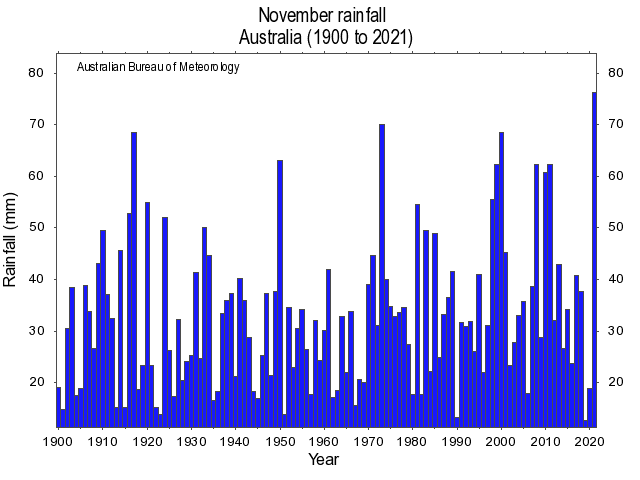

In [5]:
Image(filename='pr_BoM_1900-2021_nov_aus-mean.png')

## Observations

In [6]:
bom_ds = fileio.open_dataset(bom_file)

In [7]:
bom_ds

<xarray.Dataset>
Dimensions:  (time: 122)
Coordinates:
  * time     (time) object 1900-11-15 00:00:00 ... 2021-11-15 00:00:00
Data variables:
    pr       (time) float64 dask.array<chunksize=(122,), meta=np.ndarray>
Attributes:
    history:  Fri Feb 18 11:06:30 2022: /g/data/xv83/dbi599/miniconda3/envs/u...
    source:   http://www.bom.gov.au/climate/change/

In [8]:
years = bom_ds['time'].dt.year.values
bom_df = pd.DataFrame(index=years)
bom_df['pr'] = bom_ds['pr'].values

In [9]:
mean_rainfall = bom_df.mean()
print(mean_rainfall)

pr    32.909262
dtype: float64


In [10]:
ranked_years = bom_df['pr'].sort_values(ascending=False)
ranked_years.head(n=10)

2021    76.18
1973    70.14
1917    68.51
2000    68.41
1950    63.03
2008    62.38
1999    62.30
2011    62.29
2010    60.67
1998    55.49
Name: pr, dtype: float64

## Model ensemble

In [11]:
model_ds = fileio.open_dataset(model_file)
model_bc_ds = fileio.open_dataset(model_bc_file)

In [12]:
model_ds

<xarray.Dataset>
Dimensions:    (ensemble: 10, init_date: 60, lead_time: 11)
Coordinates:
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 8 9
  * init_date  (init_date) object 1960-11-16 00:00:00 ... 2019-11-16 00:00:00
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    time       (lead_time, init_date) object dask.array<chunksize=(11, 60), meta=np.ndarray>
Data variables:
    pr         (init_date, ensemble, lead_time) float64 dask.array<chunksize=(1, 1, 11), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.6.0
    ...                     ...
    table_id:               Amon
    table_info:             Creation Date:(05 February 2020) MD5:6a248fd76c55...
    title:                  CMCC-CM2-SR5 output prepared for CMIP6
    tracking_id:            hdl:21.14100/9030313a-075d-4030-beea-5414dde0ee00
    variable_id:            pr
    variant_label:          r1i1p1f1

### Independence testing

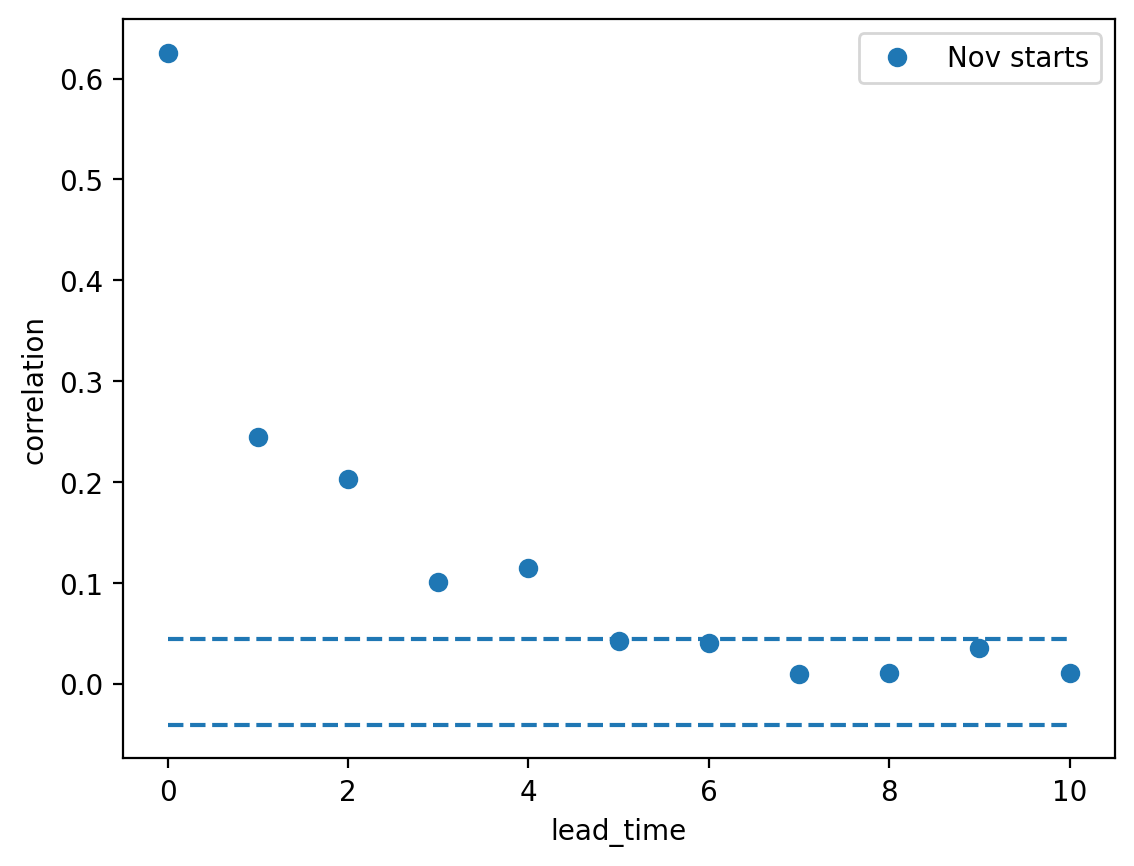

In [13]:
Image(filename=independence_plot)

In [14]:
model_da = model_ds['pr'].where(model_ds['lead_time'] >= min_lead)

### Bias correction and similarity testing

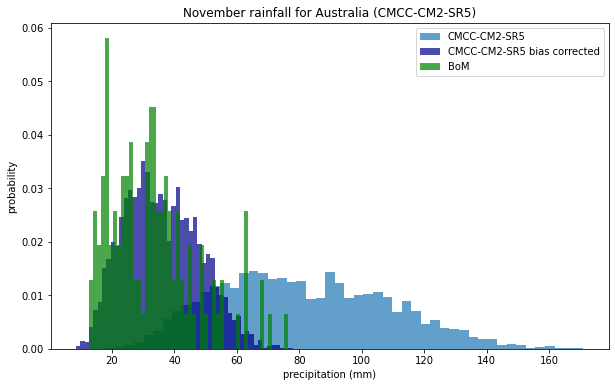

In [15]:
fig = plt.figure(figsize=[10, 6])
model_da.plot.hist(bins=50, density=True, label=model_name, alpha=0.7)
model_bc_ds['pr'].plot.hist(bins=50, density=True, label=f'{model_name} bias corrected', facecolor='darkblue', alpha=0.7)
bom_ds['pr'].plot.hist(bins=50, density=True, label='BoM', facecolor='green', alpha=0.7)
plt.xlabel('precipitation (mm)')
plt.ylabel('probability')
plt.title(f'November rainfall for Australia ({model_name})')
plt.legend()
plt.savefig(f'/g/data/xv83/dbi599/nov-rain/figures/nov_precip_histogram_aus_{model_name}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [16]:
similarity_bias_ds = fileio.open_dataset(similarity_bc_file)
similarity_bias_ds['pval'].values

array([0.3086527 , 0.81898512, 0.47734988, 0.24173559, 0.26709214,
       0.20712453])

In [17]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)
similarity_raw_ds['pval'].values

array([1.24388034e-31, 2.60098860e-36, 1.23181874e-23, 4.09333851e-29,
       2.60098860e-36, 6.53462484e-36, 6.22765525e-30, 2.76573350e-31,
       2.76573350e-31, 1.07427748e-32, 8.31528427e-32])

These are the p-values for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

### Exceedance curves

In [18]:
pr2021 = bom_ds['pr'].values.max()
print(pr2021)

76.18


#### Bias corrected data

In [19]:
model_bc_da_stacked = model_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [20]:
model_bc_da_stacked.shape

(3600,)

In [21]:
sorted_data_bc, exceedance_bc = general_utils.exceedance_curve(model_bc_da_stacked.data)

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/dask/array/core.py:1508: FutureWarning: The `numpy.sort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


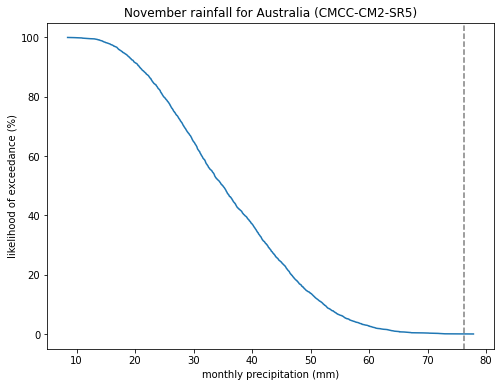

In [22]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
ax.plot(sorted_data_bc, exceedance_bc)
ax.set_title(f'November rainfall for Australia ({model_name})')
ax.set_ylabel('likelihood of exceedance (%)')
ax.set_xlabel('monthly precipitation (mm)')
ax.axvline(pr2021, color='0.5', linestyle='--')
plt.savefig(f'/g/data/xv83/dbi599/nov-rain/figures/nov_precip_exceedence_aus_{model_name}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [23]:
percentile_bc, return_period_bc = general_utils.event_in_context(model_bc_da_stacked.values, pr2021, 'above')
print('BIAS CORRECTED DATA')
print(f'{percentile_bc:.2f}% percentile')
print(f'{return_period_bc:.0f} year return period')

BIAS CORRECTED DATA
99.97% percentile
3600 year return period


#### Raw data

In [24]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [25]:
model_da_stacked.shape

(3600,)

In [26]:
sorted_data, exceedance = general_utils.exceedance_curve(model_da_stacked.data)

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/dask/array/core.py:1508: FutureWarning: The `numpy.sort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


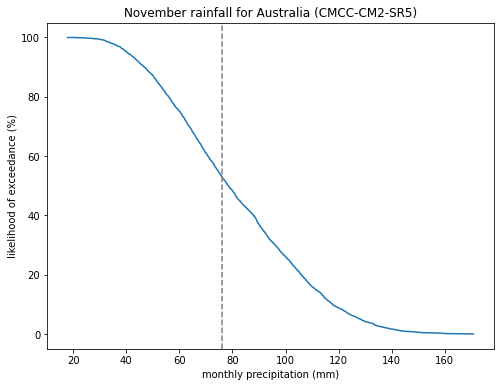

In [27]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
ax.plot(sorted_data, exceedance)
ax.set_title(f'November rainfall for Australia ({model_name})')
ax.set_ylabel('likelihood of exceedance (%)')
ax.set_xlabel('monthly precipitation (mm)')
ax.axvline(pr2021, color='0.5', linestyle='--')
plt.savefig(f'/g/data/xv83/dbi599/nov-rain/figures/nov_precip_exceedence_aus_{model_name}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [28]:
percentile, return_period = general_utils.event_in_context(model_da_stacked.values, pr2021, 'above')
print('RAW DATA')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

RAW DATA
47.08% percentile
2 year return period
